In [123]:
# Packages for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

# Packages for PostgreSQL Import
import psycopg2

# Custom packages with database connection information (Not working)
    #from projectname.config import dbname, username, pswd

In [12]:
# Ideally I'll move this into the project config.py file
# Otherwise for now I have to just manually assign . . .

dbname = "freelance_db"
username = "Metaverse"
pswd = "Arcifice91"

In [13]:
# Connect to Data (from: scraping_data.ipynb)

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Column reference
sql_query = """SELECT * FROM INFORMATION_SCHEMA.TABLES;"""
col_ref = pd.read_sql_query(sql_query,con)
col_ref[col_ref['table_schema'] == "public"]['table_name']

0           freelance_db
3          details_table
7     user_details_table
20       freelance_table
Name: table_name, dtype: object

In [14]:
# Checking shapes of tables
sql_query = """SELECT * from user_details_table;"""
dtls_table = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * from freelance_table;"""
fl_table = pd.read_sql_query(sql_query, con)

print(dtls_table.shape)
print(fl_table.shape)

(1020, 9)
(4539, 10)


In [15]:
# Creating merged dataset
dtls_table['profile_url'] = "https://www.guru.com"+dtls_table['profile_url']

In [174]:
all_table = pd.merge(fl_table, dtls_table, on='profile_url')
all_table.shape
all_table = all_table.drop(columns=(['index_x']))
all_table = all_table.drop_duplicates(subset='profile_url')
print(all_table.shape)

(979, 17)


In [175]:
# Merging in State Regions
state_region_crswlk = pd.read_csv('~/Desktop/Insight/projects/myrate/data/raw/census-regions/us census bureau regions and divisions.csv')
state_region_crswlk.head()

all_table = pd.merge(all_table, state_region_crswlk, how='left', left_on='state', right_on='State')


In [176]:
all_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile_url       979 non-null    object
 1   city              979 non-null    object
 2   state             979 non-null    object
 3   country           979 non-null    object
 4   rating            979 non-null    object
 5   earnings          979 non-null    object
 6   hourly_rate       979 non-null    int64 
 7   skills_list       979 non-null    object
 8   user_description  979 non-null    object
 9   index_y           979 non-null    int64 
 10  member_since      979 non-null    object
 11  earnings_pst_yr   948 non-null    object
 12  earnings_ever     948 non-null    object
 13  employers         948 non-null    object
 14  invoices_paid     948 non-null    object
 15  largest_employ    948 non-null    object
 16  bio               948 non-null    object
 17  State           

In [47]:
# Inspecting null merges with region data
all_table[all_table['State'].isna()]
    # Ah, it is someone in Puerto Rico. Making their Region "Other"
all_table.loc[all_table['state'] == "Puerto Rico",'Region'] = "Other"

### EDA for 'all_table'

In [66]:
# Basic descriptives: Outcome - hourly_rate
all_table['hourly_rate'].mean()

31.93667007150153

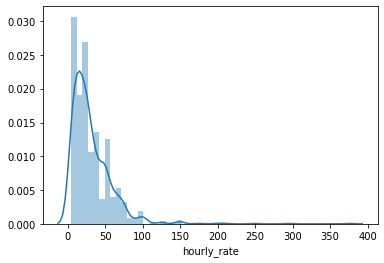

In [67]:
# Distribution
sns.distplot(all_table['hourly_rate'])

In [68]:
# Number of different cities and states?
print("Number of cities: " + str(all_table['city'].nunique()))
print("Number of states: " + str(all_table['state'].nunique()))

Number of cities: 660
Number of states: 50


In [70]:
# All United States? Yes.
#print(all_table['state'].drop_duplicates())

In [71]:
# Can do much much much more from here:
    # 1. Different cities
        # - rate distribution by city?
        # - Number of unique obs by city?
        # - Create a map?
    # 2. Inspect skills
        # - Number of different skills?
        # - Which skills are the most common? How does rate vary within those?
        # - Group skills (???) and calculate hourly rate 
        #   distribution by those groupings
    # 3. Inspect description
        # - Text analysis of some kind.
        # - Also will need to go back and scrape info from the user pages.
        #   Could also try Selenium but may be faster to just scrape on static page.
        #   Nvm. Will have to use Selenium.

### Inspecting the outcome (hourly rate) by state

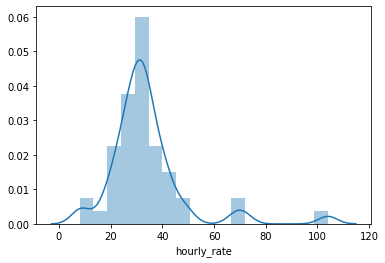

In [72]:
# Distribution of hourly rates by state?
sns.distplot(all_table.drop_duplicates().groupby('state').mean()['hourly_rate'])

# Pretty much a normal distrbution aside from a few outliers (who are they?)

In [74]:
# Top five states with highest average hourly rates
print("Five states with the highest average hourly rates")
print(all_table.groupby('state').mean()['hourly_rate'].sort_values(ascending=False)[0:5,])
print("Five states wit hteh lowest average hourly rates")
print(all_table.groupby('state').mean()['hourly_rate'].sort_values(ascending=True)[0:5,])

# Well, here they are. Mississippi with a mean HR or 104! and then RI & MT ~= 70!
# Similarly have a couple of low end states: ND and AK @ ~= 8.5
# Everyone else respects the normal distribution

Five states with the highest average hourly rates
state
Mississippi     104.000000
Rhode Island     71.500000
Montana          68.333333
Vermont          49.800000
Utah             47.500000
Name: hourly_rate, dtype: float64
Five states wit hteh lowest average hourly rates
state
North Dakota     8.000000
Arkansas         9.142857
Nebraska        16.666667
Idaho           19.500000
Puerto Rico     20.000000
Name: hourly_rate, dtype: float64


Counts of observations by state


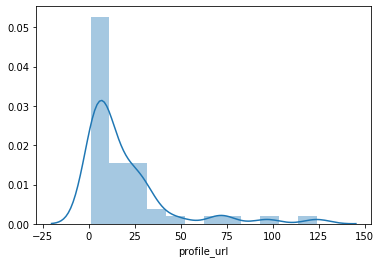

In [81]:
# What are the counts within each state?
print("Counts of observations by state")
dt_tmp = all_table.groupby('state').count()['profile_url'].sort_values(ascending=False)
sns.distplot(dt_tmp)

# Ooof, really small obs in some states.

In [88]:
# Counts within each state
print("Five states with lowest counts")
print(all_table.groupby('state').count()['profile_url'].sort_values(ascending=True)[0:5])

print("Five states with largest counts")
print(all_table.groupby('state').count()['profile_url'].sort_values(ascending=False)[0:5])

# No one in some states and alot of people in other states . . .

Five states with lowest counts
state
North Dakota     1
Wyoming          2
West Virginia    2
South Dakota     2
Rhode Island     2
Name: profile_url, dtype: int64
Five states with largest counts
state
California      124
Florida          97
New York         74
Texas            70
Pennsylvania     49
Name: profile_url, dtype: int64


### Inspecting outcome by region

Note: There doesn't seem to be a signal. Could we cut this up further though? Urban vs rural?

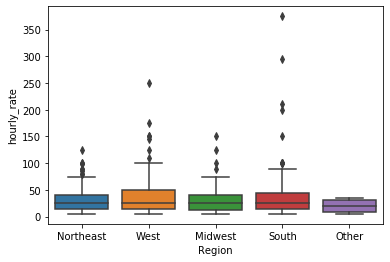

In [40]:
# What is the distribution by region?
sns.boxplot(x="Region", y="hourly_rate", data=all_table)

# There doesn't seem to be much of a signal by region

### Merging in City Data

Lose 114 observations. . . would take some hand recoding to get them back.

This merge isn't worth the effort right now.

In [94]:
# Merging in City Data - https://simplemaps.com/data/us-cities    
# Data is unique at city | state_name
# city_dt = pd.read_csv('/Users/Metaverse/Desktop/Insight/projects/myrate/data/raw/simplemaps_uscities_basicv1.6/uscities.csv')
# city_dt['city'] = city_dt['city'].str.lower()
# all_table['city'] = all_table['city'].str.lower()
# all_table = pd.merge(all_table, city_dt,  how='left', left_on=['city','state'], right_on = ['city','state_name'])
# all_table.info()


### Looking at "Rating"

Not much here either.

In [159]:
# Distrbution of ratings - First I have to clean it up
all_table.rating = all_table.rating.str.replace('%','')
all_table.rating = all_table.rating.str.replace('NA','')
all_table.rating = pd.to_numeric(all_table.rating)

In [160]:
# Distribution of ratings (not there are a a good amount of NAS)
print(all_table.rating.isna().sum())
all_table.rating.describe()

68


count    911.000000
mean      98.424040
std       11.376479
min        1.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: rating, dtype: float64

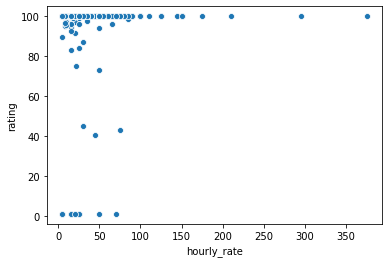

In [161]:
# All table connection to the outcome - Not very informative.
sns.scatterplot(x="hourly_rate", y="rating", data=all_table)

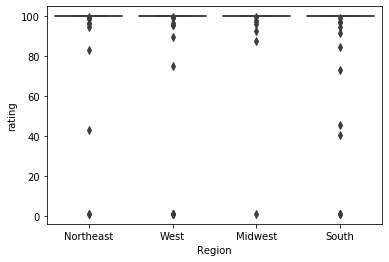

In [162]:
# Distribution of ratings by region? Nope, no relation
sns.boxplot(x="Region", y="rating", data=all_table)

### How long have they been a member?

1. Convert member start date to a date object
2. Calculate years / months they've been a member (to today)

In [196]:
def date_convert(member_since):
    try:
        tmp = datetime.strptime(member_since, '%b, %Y')
        #tmp = tmp.strftime('%Y-%m')
    except:
        tmp = 'NaN'
    return tmp

In [209]:
def years_active(date):
    cur_year = datetime.now().year
    try:
        yrs_active = cur_year - date.year
    except:
        yrs_active = 'NaN'
    
    return yrs_active

In [215]:
def months_active(date):
    cur_year = datetime.now().year
    cur_month = datetime.now().month
    
    try:
        mnths_active = (cur_year - date.year)*12 + (cur_month - date.month)
    except:
        mnths_active = 'NaN'
        
    return mnths_active

In [197]:
# How many NAs are there?
all_table.member_since[all_table.member_since == 'NA'].count()

21

In [216]:
# Converting member_since to date
all_table.member_since = all_table.member_since.str.strip()
all_table['start_date'] = all_table.member_since.apply(date_convert)
all_table['years_active'] = all_table.start_date.apply(years_active)
all_table['months_active'] = all_table.start_date.apply(months_active)

### Inspecting the number of skills and outcome by it